# Test 6: Horizontal Counter-Flow Assessment

The ability of evacuation models to simulate horizontal counter-flows shall be verified. Current testing should be intended only as a verification of the qualitative abilities of models to represent counterflows, i.e. no evaluation of the expected occupant trajectories is included. Nevertheless, once a sufficient body of benchmark experiments on occupant trajectories is available for comparison, testing can be expanded in order to include the analysis of occupant trajectories (i.e. it can become a validation test).

**Source: Fire safety engineering — Verification and validation protocol for building fire evacuation models**

**INTERNATIONAL STANDARD ISO 20414**


In [1]:
import pathlib

import jupedsim as jps
import matplotlib.pyplot as plt

import pedpy
from numpy.random import normal  # normal distribution of free movement speed
from shapely import GeometryCollection, Polygon
from jupedsim.internal.notebook_utils import animate, read_sqlite_file

## Geometry Setup

By creating the union of all parts we end up with the whole walkable area.
we will use the functionalities of [pedpy](https://pedpy.readthedocs.io/en/stable/) to plot geometries and analyse the trajectories.


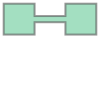

In [2]:
room1 = Polygon([(0, 0), (10, 0), (10, 10), (0, 10)])
room2 = Polygon([(20, 0), (30, 0), (30, 10), (20, 10)])
corridor = Polygon([(10, 4.0), (20, 4.0), (20, 6.0), (10, 6.0)])

area = GeometryCollection(corridor.union(room1.union(room2)))
walkable_area = pedpy.WalkableArea(area.geoms[0])
area
# pedpy.plot_walkable_area(walkable_area=walkable_area)

## Definition of Start Positions and Exit

Now we define the spawning area according to RiMEA and calculate 150 positions within that area. The exit area is defined at the end of the corridor.


In [3]:
num_agents = 14
trajectory_file = "double-botteleneck.sqlite"
v_distribution = normal(1.34, 0.05, num_agents)
spawning_area_right = Polygon([(28, 0), (30, 0), (30, 10), (28, 10)])
spawning_area_left = Polygon([(0, 0), (2, 0), (2, 10), (0, 10)])

exit_area_right = Polygon([(29, 4.5), (30, 4.5), (30, 5.5), (29, 5.5)])
exit_area_left = Polygon([(0, 4.5), (1, 4.5), (1, 5.5), (0, 5.5)])

In [9]:
def plot_simulation_configuration(axes, spawning_area, exit_area):
    axes.fill(*spawning_area.exterior.xy, color="lightgrey")
    axes.fill(*exit_area.exterior.xy, color="indianred")
    axes.set_xlabel("x/m")
    axes.set_ylabel("y/m")
    axes.set_aspect("equal")

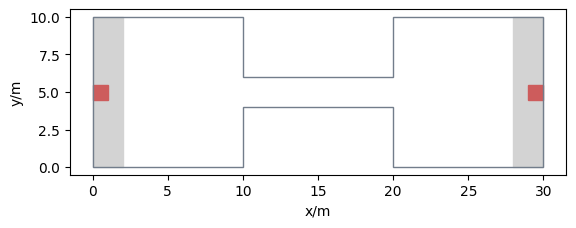

In [10]:
axes = pedpy.plot_walkable_area(walkable_area=walkable_area)
plot_simulation_configuration(
    axes, spawning_area_right, exit_area_right
)
plot_simulation_configuration(
    axes, spawning_area_left, exit_area_left
)

## Helper functions to setup simulation

- create a simulation object
- add agents to simulation
- run simulation scenarios

In [6]:
def create_simulation(exit_areas, trajectory_file):
    simulation = jps.Simulation(
        model=jps.CollisionFreeSpeedModel(),
        geometry=area,
        trajectory_writer=jps.SqliteTrajectoryWriter(
            output_file=pathlib.Path(trajectory_file)
        ),
    )
    exit_ids = []
    _journey_ids = []
    for exit_area in exit_areas:
        exit_id = simulation.add_exit_stage(exit_area.exterior.coords[:-1])
        exit_ids.append(exit_id)
        journey = jps.JourneyDescription([exit_id])
        journey_id = simulation.add_journey(journey)
        _journey_ids.append(journey_id)

    return simulation, _journey_ids, exit_ids

def add_agents_to_simulation(
    simulation, journey_id, stage_id, positions, v0=1.2, radius=0.15
):
    for pos in positions:
        agent_params = jps.CollisionFreeSpeedModelAgentParameters(
            journey_id=journey_id,
            stage_id=stage_id,
            position=pos,
            v0=v0,
            radius=radius,
        )
        simulation.add_agent(agent_params)


def run_simulation_scenarios(scenarios, seeds, trajectory_base_filename="double_bottleneck"):
    results = []
    for seed in seeds:
        for agents_left, agents_right in scenarios:
            # Ensure the total number of agents remains constant at 100
            if agents_left + agents_right != 100:
                raise ValueError("Total agents must equal 100")

            trajectory_file = f"{trajectory_base_filename}_{agents_left}_{agents_right}.sqlite"
            
            simulation, journey_ids, exit_ids = create_simulation(
                [exit_area_right, exit_area_left], trajectory_file
            )
            journey_id_right, journey_id_left = journey_ids
            exit_id_right, exit_id_left = exit_ids

            # Distribute agents for both left and right spawning areas using the same seed
            pos_in_spawning_area_right = jps.distributions.distribute_by_number(
                polygon=spawning_area_right,
                number_of_agents=agents_right,
                distance_to_agents=0.3,
                distance_to_polygon=0.15,
                seed=seed,
            )
            pos_in_spawning_area_left = jps.distributions.distribute_by_number(
                polygon=spawning_area_left,
                number_of_agents=agents_left,
                distance_to_agents=0.3,
                distance_to_polygon=0.15,
                seed=seed,
            )
            
            # Add agents for each spawning area
            add_agents_to_simulation(
                simulation, journey_id_left, exit_id_left, pos_in_spawning_area_right
            )
            add_agents_to_simulation(
                simulation, journey_id_right, exit_id_right, pos_in_spawning_area_left
            )

            # Run the simulation
            while simulation.agent_count() > 0:
                simulation.iterate()

            # Record the elapsed time for this scenario
            time_elapsed = simulation.elapsed_time()
            results.append((agents_left, agents_right, seed, time_elapsed))
            print(f"Simulation finished for {agents_left} left agents and {agents_right} right agents.")
            print(f">> Elapsed time: {time_elapsed:.2f} s")

    return results       

## Setup simulation and run simulation

In [7]:
scenarios = [(100, 0), (80, 20), (60, 40), (50, 50)]
seeds = [10, 1000, 20, 2000, 30, 4000]
time_elapsed_list = run_simulation_scenarios(scenarios=scenarios, seeds=seeds)

Simulation finished for 100 left agents and 0 right agents.
>> Elapsed time: 55.43 s
Simulation finished for 80 left agents and 20 right agents.
>> Elapsed time: 90.07 s
Simulation finished for 60 left agents and 40 right agents.
>> Elapsed time: 118.53 s
Simulation finished for 50 left agents and 50 right agents.
>> Elapsed time: 123.29 s
Simulation finished for 100 left agents and 0 right agents.
>> Elapsed time: 55.45 s
Simulation finished for 80 left agents and 20 right agents.
>> Elapsed time: 81.71 s
Simulation finished for 60 left agents and 40 right agents.
>> Elapsed time: 91.00 s
Simulation finished for 50 left agents and 50 right agents.
>> Elapsed time: 86.09 s
Simulation finished for 100 left agents and 0 right agents.
>> Elapsed time: 55.64 s
Simulation finished for 80 left agents and 20 right agents.
>> Elapsed time: 78.47 s
Simulation finished for 60 left agents and 40 right agents.
>> Elapsed time: 103.60 s
Simulation finished for 50 left agents and 50 right agents.
>>

<Figure size 1000x600 with 0 Axes>

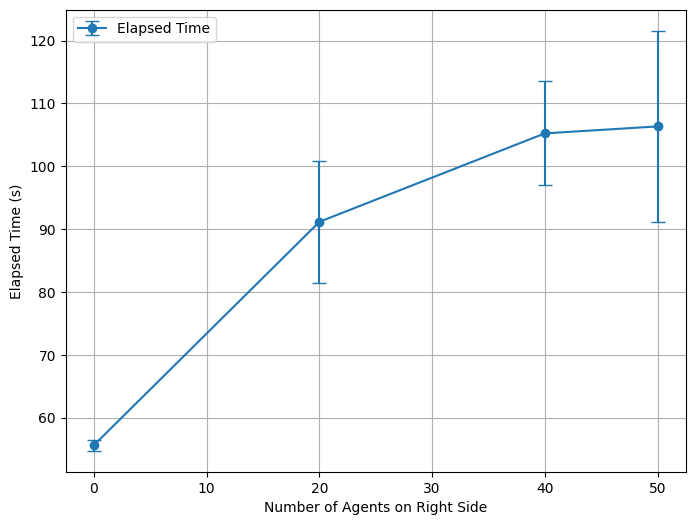

In [11]:
import numpy as np
plt.figure(figsize=(10, 6))
right_agents = sorted({entry[1] for entry in time_elapsed_list})
mean_times = []
std_dev_times = []

# Calculate mean and standard deviation for each right_agents count
for right_count in right_agents:
    times = [entry[3] for entry in time_elapsed_list if entry[1] == right_count]
    mean_times.append(np.mean(times))
    std_dev_times.append(np.std(times))

plt.figure(figsize=(8, 6))
plt.errorbar(right_agents, mean_times, yerr=std_dev_times, fmt='o-', capsize=5, label='Elapsed Time')
plt.xlabel('Number of Agents on Right Side')
plt.ylabel('Elapsed Time (s)')
plt.legend()
plt.grid(True)